In [1]:
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 11})
# PyTorch
import torch
torch.manual_seed(42)
import torchvision
import torchmetrics

In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import likelihoods
import losses
import priors
import utils

In [3]:
dataset_directory = "/cluster/tufts/hugheslab/eharve06/CIFAR-10"
n = 1000
tune = False
random_state = 1001
augmented_train_dataset, train_dataset, val_or_test_dataset = utils.get_cifar10_datasets(dataset_directory, n, tune, random_state)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 128
num_workers = 0
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_dataset, batch_size=min(batch_size, len(augmented_train_dataset)), shuffle=True, num_workers=num_workers, drop_last=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(batch_size, len(train_dataset)), num_workers=num_workers)
val_or_test_loader = torch.utils.data.DataLoader(val_or_test_dataset, batch_size=batch_size, num_workers=num_workers)

In [5]:
num_classes = 10

model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
num_classifier_params = (2048 * num_classes) + num_classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

model.raw_sigma = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4, device=device))))
utils.add_variational_layers(model, model.raw_sigma)
model.use_posterior = types.MethodType(utils.use_posterior, model)

backbone_prior_params = torch.load("/cluster/tufts/hugheslab/eharve06/resnet50_torchvision/resnet50_torchvision_mean.pt", map_location=device, weights_only=False)

likelihood =likelihoods.CategoricalLikelihood(num_classes=num_classes)
backbone_prior = priors.IsotropicGaussianPrior(learnable_tau=True, prior_params=backbone_prior_params, use_tau_star=True)
classifier_prior = priors.IsotropicGaussianPrior(learnable_tau=True, num_params=num_classifier_params, use_tau_star=True)

likelihood.to(device)
backbone_prior.to(device)
classifier_prior.to(device)

criterion = losses.TransferLearningTemperedELBOLoss(model, likelihood, backbone_prior, classifier_prior, kappa=1.0)

cuda:0


In [6]:
deelbo_df = pd.read_csv("/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/train_eval_comparison/l2-sp_kappa=23528.522_lr_0=0.001_n=1000_random_state=1001.csv")
deelbo_checkpoint = torch.load("/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/train_eval_comparison/l2-sp_kappa=23528.522_lr_0=0.001_n=1000_random_state=1001.pt", map_location=device, weights_only=False)
deelbo_checkpoint = {k.replace("sigma_param", "raw_sigma"): v for k, v in deelbo_checkpoint.items()}
model.load_state_dict(deelbo_checkpoint)

num_samples = 10

with torch.no_grad():
    good_vector = torch.nn.utils.parameters_to_vector(model.parameters())
    good_sigma_param, good_params = good_vector[0], good_vector[1:]
    good_sampled_params = [good_params + torch.nn.functional.softplus(good_sigma_param) * torch.randn_like(good_params).to(good_params.device) for _ in range(num_samples)]

    good_sample_metrics = []
    for sampled_params in good_sampled_params:
        torch.nn.utils.vector_to_parameters(torch.hstack([good_sigma_param, sampled_params]), model.parameters())
        sample_metrics = utils.evaluate(model, criterion, train_loader)
        good_sample_metrics.append(sample_metrics)

In [7]:
elbo_df = pd.read_csv("/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/train_eval_comparison/l2-sp_kappa=1.0_lr_0=0.001_n=1000_random_state=1001.csv")
elbo_checkpoint = torch.load("/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/train_eval_comparison/l2-sp_kappa=1.0_lr_0=0.001_n=1000_random_state=1001.pt", map_location=device, weights_only=False)
elbo_checkpoint = {k.replace("sigma_param", "raw_sigma"): v for k, v in elbo_checkpoint.items()}
model.load_state_dict(elbo_checkpoint)
model.to(device)

with torch.no_grad():
    bad_vector = torch.nn.utils.parameters_to_vector(model.parameters())
    bad_sigma_param, bad_params = bad_vector[0], bad_vector[1:]
    bad_sampled_params = [bad_params + torch.nn.functional.softplus(bad_sigma_param) * torch.randn_like(bad_params).to(bad_params.device) for _ in range(num_samples)]

    bad_sample_metrics = []
    for sampled_params in bad_sampled_params:
        torch.nn.utils.vector_to_parameters(torch.hstack([bad_sigma_param, sampled_params]), model.parameters())
        sample_metrics = utils.evaluate(model, criterion, train_loader)
        bad_sample_metrics.append(sample_metrics)

In [8]:
good_model_elbo = []
good_model_deelbo = []

for eta in np.logspace(-8, 2, 1000):
    
    backbone_prior = priors.IsotropicGaussianPrior(prior_params=backbone_prior_params, tau=eta)
    classifier_prior = priors.IsotropicGaussianPrior(num_params=num_classifier_params, tau=eta)
    
    backbone_params = good_params[:backbone_prior.num_params]
    classifier_params = good_params[backbone_prior.num_params:]
    sigma = torch.nn.functional.softplus(model.raw_sigma)

    kl = backbone_prior.kl(backbone_params, sigma) + classifier_prior.kl(classifier_params, sigma)
    
    good_expected_loglikelihood = (1/num_samples) * sum(n * -sample_metrics["nll"] for sample_metrics in good_sample_metrics)
    good_model_elbo.append((good_expected_loglikelihood - kl).item())
    good_model_deelbo.append((len(good_params)/n * good_expected_loglikelihood - kl).item())

In [9]:
bad_model_elbo = []
bad_model_deelbo = []

for eta in np.logspace(-8, 2, 1000):
    
    backbone_prior = priors.IsotropicGaussianPrior(prior_params=backbone_prior_params, tau=eta)
    classifier_prior = priors.IsotropicGaussianPrior(num_params=num_classifier_params, tau=eta)
    
    backbone_params = bad_params[:backbone_prior.num_params]
    classifier_params = bad_params[backbone_prior.num_params:]
    sigma = torch.nn.functional.softplus(model.raw_sigma)

    kl = backbone_prior.kl(backbone_params, sigma) + classifier_prior.kl(classifier_params, sigma)
    
    bad_expected_loglikelihood = (1/num_samples) * sum(n * -sample_metrics["nll"] for sample_metrics in bad_sample_metrics)
    bad_model_elbo.append((bad_expected_loglikelihood - kl).item())
    bad_model_deelbo.append((len(bad_params)/n * bad_expected_loglikelihood - kl).item())

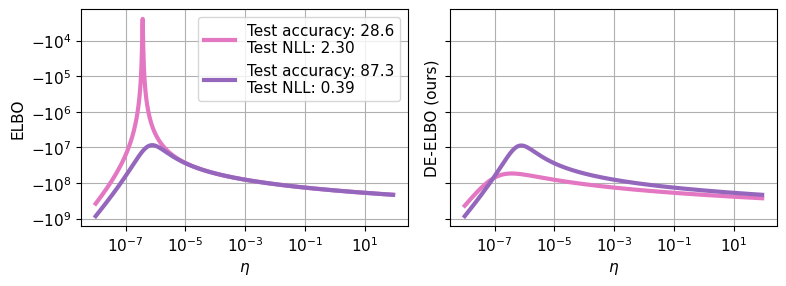

In [10]:
etas = np.logspace(-8, 2, 1000)

ncols, nrows = 2, 1

fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[1].sharey(axs[0])
axs[1].label_outer()

axs[0].plot(etas, np.array(bad_model_elbo), color="#E377C2", label="Test accuracy: 28.6\nTest NLL: 2.30", linewidth=3)
axs[0].plot(etas, np.array(good_model_elbo), color="#9467BD", label="Test accuracy: 87.3\nTest NLL: 0.39", linewidth=3)
axs[0].set_xscale("log")
axs[0].set_yscale("symlog")
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel("ELBO")
axs[0].legend()
axs[0].grid()

axs[1].plot(etas, np.array(bad_model_deelbo), color="#E377C2", linewidth=3)
axs[1].plot(etas, np.array(good_model_deelbo), color="#9467BD", linewidth=3)
axs[1].set_xscale("log")
axs[1].set_yscale("symlog")
axs[1].set_xlabel(r"$\eta$")
axs[1].set_ylabel(r"DE-ELBO (ours)")
axs[1].grid()

fig.tight_layout()
fig.savefig("model_selection.pdf", bbox_inches="tight")
plt.show()

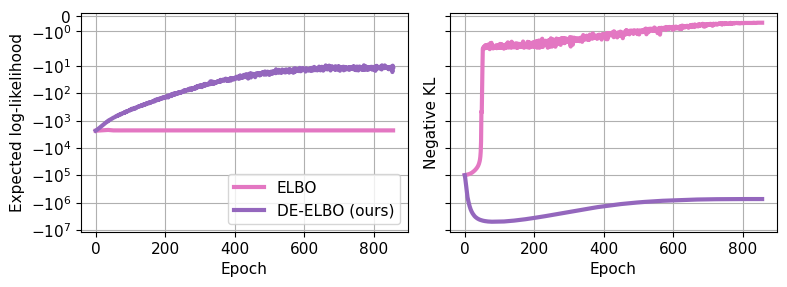

In [11]:
etas = np.logspace(-8, 2, 1000)

ncols, nrows = 2, 1

fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[1].sharey(axs[0])
axs[1].label_outer()

axs[0].plot(elbo_df.epoch, n * -elbo_df.train_nll, color="#E377C2", label="ELBO", linewidth=3)
axs[0].plot(deelbo_df.epoch, n * -deelbo_df.train_nll, color="#9467BD", label="DE-ELBO (ours)", linewidth=3)
axs[0].set_yscale("symlog")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Expected log-likelihood")
axs[0].legend(loc="lower right")
axs[0].grid()

axs[1].plot(elbo_df.epoch, -elbo_df.train_kl, color="#E377C2", linewidth=3)
axs[1].plot(deelbo_df.epoch, -deelbo_df.train_kl, color="#9467BD", linewidth=3)
axs[1].set_yscale("symlog")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Negative KL")
axs[1].grid()

fig.tight_layout()
fig.savefig("model_training.pdf", bbox_inches="tight")
plt.show()

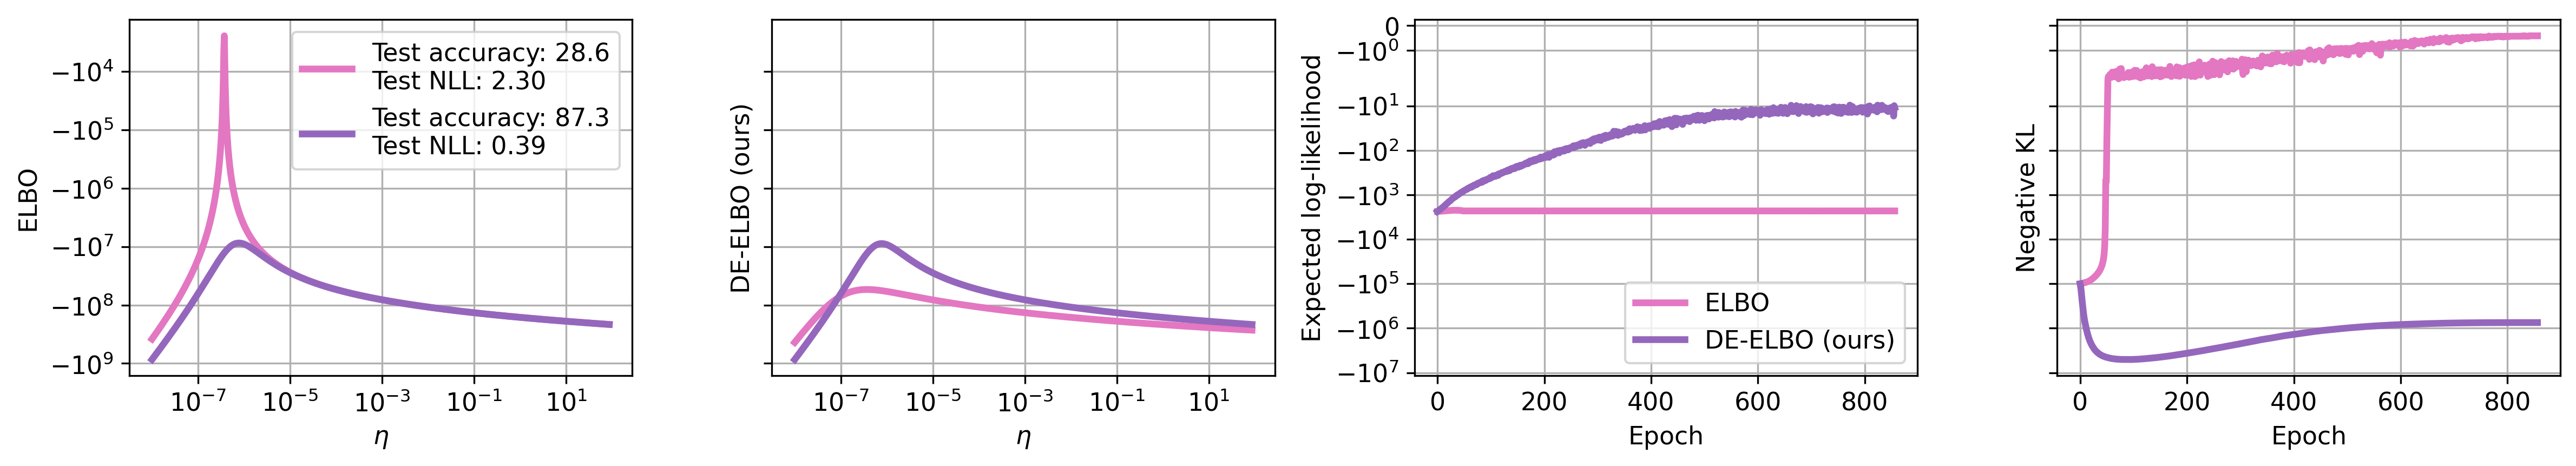

In [12]:
logspace = np.logspace(-8, 2, 1000)

ncols, nrows = 4, 1

fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), dpi=300, ncols=ncols, nrows=nrows)

axs[1].sharey(axs[0])
axs[1].label_outer()

axs[3].sharey(axs[2])
axs[3].label_outer()

axs[0].plot(logspace, np.array(bad_model_elbo), color="#E377C2", label="Test accuracy: 28.6\nTest NLL: 2.30", linewidth=3)
axs[0].plot(logspace, np.array(good_model_elbo), color="#9467BD", label="Test accuracy: 87.3\nTest NLL: 0.39", linewidth=3)
axs[0].set_xscale("log")
axs[0].set_yscale("symlog")
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel("ELBO")
axs[0].legend()
axs[0].grid()

axs[1].plot(logspace, np.array(bad_model_deelbo), color="#E377C2", linewidth=3)
axs[1].plot(logspace, np.array(good_model_deelbo), color="#9467BD", linewidth=3)
axs[1].set_xscale("log")
axs[1].set_yscale("symlog")
axs[1].set_xlabel(r"$\eta$")
axs[1].set_ylabel(r"DE-ELBO (ours)")
axs[1].grid()

axs[2].plot(elbo_df.epoch, n * -elbo_df.train_nll, color="#E377C2", label="ELBO", linewidth=3)
axs[2].plot(deelbo_df.epoch, n * -deelbo_df.train_nll, color="#9467BD", label="DE-ELBO (ours)", linewidth=3)
axs[2].set_yscale("symlog")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Expected log-likelihood")
axs[2].legend(loc="lower right")
axs[2].grid()

axs[3].plot(elbo_df.epoch, -elbo_df.train_kl, color="#E377C2", linewidth=3)
axs[3].plot(deelbo_df.epoch, -deelbo_df.train_kl, color="#9467BD", linewidth=3)
axs[3].set_yscale("symlog")
axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Negative KL")
axs[3].grid()

fig.tight_layout()
fig.savefig("elbo_comparison.pdf", bbox_inches="tight")
plt.show()

In [13]:
with torch.no_grad():
    good_model_iwelbo = []
    good_model_deiwelbo = []

    for eta in np.logspace(-8, 2, 1000):
        
        sample_iwelbo = []
        sample_deiwelbo = []
        
        lambda_star = torch.tensor(eta, device=device)
        tau_star = torch.tensor(eta, device=device)
        
        bb_p = torch.distributions.independent.Independent(torch.distributions.normal.Normal(backbone_prior_params, torch.sqrt(lambda_star)), 1)
        bb_q = torch.distributions.independent.Independent(torch.distributions.normal.Normal(good_params[:len(backbone_prior_params)], torch.nn.functional.softplus(good_sigma_param)), 1)
        clf_p = torch.distributions.independent.Independent(torch.distributions.normal.Normal(torch.zeros_like(good_params[len(backbone_prior_params):]), torch.sqrt(tau_star)), 1)
        clf_q = torch.distributions.independent.Independent(torch.distributions.normal.Normal(good_params[len(backbone_prior_params):], torch.nn.functional.softplus(good_sigma_param)), 1)
        
        for sample_metrics, sampled_params in zip(good_sample_metrics, good_sampled_params):
            sample_iwelbo.append(n * -sample_metrics["nll"] + (bb_p.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_p.log_prob(sampled_params[len(backbone_prior_params):])) - (bb_q.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_q.log_prob(sampled_params[len(backbone_prior_params):])))
            sample_deiwelbo.append(len(good_params) * -sample_metrics["nll"] + (bb_p.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_p.log_prob(sampled_params[len(backbone_prior_params):])) - (bb_q.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_q.log_prob(sampled_params[len(backbone_prior_params):])))
        
        good_model_iwelbo.append(np.log(1/num_samples) + torch.logsumexp(torch.stack(sample_iwelbo), dim=0).item())
        good_model_deiwelbo.append(np.log(1/num_samples) + torch.logsumexp(torch.stack(sample_deiwelbo), dim=0).item())

In [14]:
with torch.no_grad():
    bad_model_iwelbo = []
    bad_model_deiwelbo = []

    for eta in np.logspace(-8, 2, 1000):
        
        sample_iwelbo = []
        sample_deiwelbo = []
        
        lambda_star = torch.tensor(eta, device=device)
        tau_star = torch.tensor(eta, device=device)
        
        bb_p = torch.distributions.independent.Independent(torch.distributions.normal.Normal(backbone_prior_params, torch.sqrt(lambda_star)), 1)
        bb_q = torch.distributions.independent.Independent(torch.distributions.normal.Normal(bad_params[:len(backbone_prior_params)], torch.nn.functional.softplus(bad_sigma_param)), 1)
        clf_p = torch.distributions.independent.Independent(torch.distributions.normal.Normal(torch.zeros_like(bad_params[len(backbone_prior_params):]), torch.sqrt(tau_star)), 1)
        clf_q = torch.distributions.independent.Independent(torch.distributions.normal.Normal(bad_params[len(backbone_prior_params):], torch.nn.functional.softplus(bad_sigma_param)), 1)
        
        for sample_metrics, sampled_params in zip(bad_sample_metrics, bad_sampled_params):
            sample_iwelbo.append(n * -sample_metrics["nll"] + (bb_p.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_p.log_prob(sampled_params[len(backbone_prior_params):])) - (bb_q.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_q.log_prob(sampled_params[len(backbone_prior_params):])))
            sample_deiwelbo.append(len(bad_params) * -sample_metrics["nll"] + (bb_p.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_p.log_prob(sampled_params[len(backbone_prior_params):])) - (bb_q.log_prob(sampled_params[:len(backbone_prior_params)]) + clf_q.log_prob(sampled_params[len(backbone_prior_params):])))
        
        bad_model_iwelbo.append(np.log(1/num_samples) + torch.logsumexp(torch.stack(sample_iwelbo), dim=0).item())
        bad_model_deiwelbo.append(np.log(1/num_samples) + torch.logsumexp(torch.stack(sample_deiwelbo), dim=0).item())

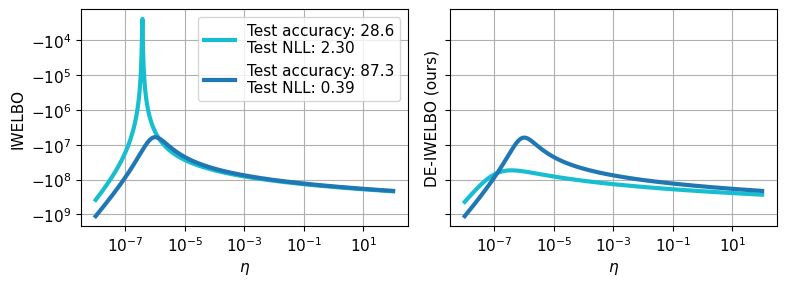

In [15]:
etas = np.logspace(-8, 2, 1000)

ncols, nrows = 2, 1

fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

axs[1].sharey(axs[0])
axs[1].label_outer()

axs[0].plot(etas, np.array(bad_model_iwelbo), color="#17BECF", label="Test accuracy: 28.6\nTest NLL: 2.30", linewidth=3)
axs[0].plot(etas, np.array(good_model_iwelbo), color="#1F77B4", label="Test accuracy: 87.3\nTest NLL: 0.39", linewidth=3)
axs[0].set_xscale("log")
axs[0].set_yscale("symlog")
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel("IWELBO")
axs[0].legend()
axs[0].grid()

axs[1].plot(etas, np.array(bad_model_deiwelbo), color="#17BECF", linewidth=3)
axs[1].plot(etas, np.array(good_model_deiwelbo), color="#1F77B4", linewidth=3)
axs[1].set_xscale("log")
axs[1].set_yscale("symlog")
axs[1].set_xlabel(r"$\eta$")
axs[1].set_ylabel(r"DE-IWELBO (ours)")
axs[1].grid()

fig.tight_layout()
fig.savefig("iwelbo_comparison.pdf", bbox_inches="tight")
plt.show()